# Experimentation with 'graph' style inputs

- [Convenience Accessor](#Convenience-Accessor-for-CellGeo)
- ['Average' Image Generation](#'Average'-Image-Generation)
- [Validation on Single Clusters](#Validation-on-Single-Clusters)
- [Final Code](#Final-Code)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import scipy
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl

ampl.use_atlas_style()
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

path_prefix = '/AL/Phd/maxml/'
plotpath = path_prefix+'caloml-atlas/inputs/Plots/'
modelpath = path_prefix+'caloml-atlas/classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# # metadata
# layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
# cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
# cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
# len_phi = [4, 16, 16, 4, 4, 4]
# len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
import sys
sys.path.append(path_prefix+'caloml-atlas/')
sys.path
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [4]:
inputpath = path_prefix+'caloml-atlas/inputs/'
branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta',
            'truthPhi', 'clusterIndex', 'nCluster', 'clusterE',
            'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi',
            'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT',
            'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT',
            'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT',
            'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG',
            'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min',
            'cluster_cell_dR_max', 'cluster_cell_dEta_min',
            'cluster_cell_dEta_max', 'cluster_cell_dPhi_min',
            'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta',
            'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer',
            'cluster_cellE_norm']
geo_branches = [
    'cell_geo_ID', 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi',
    'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi', 'cell_geo_volume',
    'cell_geo_sigma'
]

In [8]:
infile = ur.open(inputpath+'single_pion.mltree.root')

In [8]:
infile.keys()

[b'EventTree;1', b'CellGeo;1']

In [14]:
pdata['cell_geo_ID']

entry
0    [740294656, 740294658, 740294660, 740294662, 7...
Name: cell_geo_ID, dtype: object

In [18]:
infile['CellGeo'].keys()

[b'cell_geo_ID',
 b'cell_geo_sampling',
 b'cell_geo_eta',
 b'cell_geo_phi',
 b'cell_geo_rPerp',
 b'cell_geo_deta',
 b'cell_geo_dphi',
 b'cell_geo_volume',
 b'cell_geo_sigma']

In [7]:
pdata = infile['CellGeo'].arrays(geo_branches,library='pd')

In [9]:
infile['CellGeo'].num_entries

1

In [10]:
infile['EventTree'].num_entries

2000

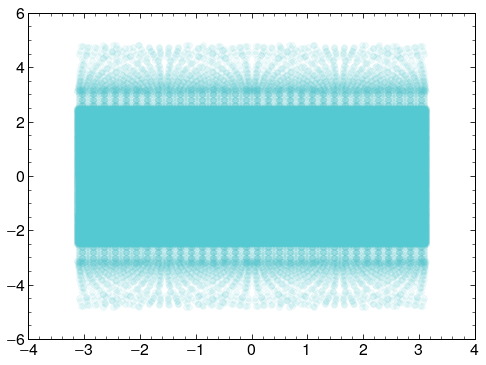

In [12]:
plt.scatter(pdata['cell_geo_phi'],pdata['cell_geo_eta'],alpha=0.1)

(array([ 7808., 58752., 29184., 13824.,  1536., 27648., 23424., 11136.,
         1536.,  1472.,  1344.,  1280.,  1280.,  1152.,   448.,   128.,
          126.,   512.,   640.,   640.,   256.,  2016.,  1508.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <BarContainer object of 23 artists>)

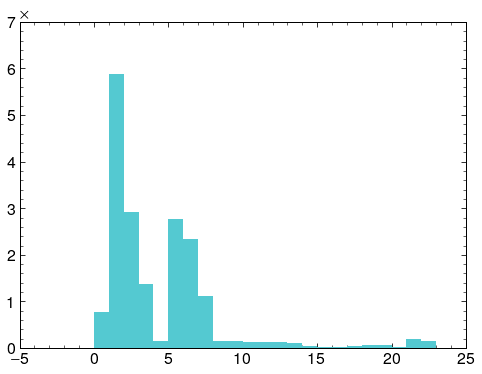

In [20]:
plt.hist(pdata['cell_geo_sampling'],bins=range(24))

c:\users\akong\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


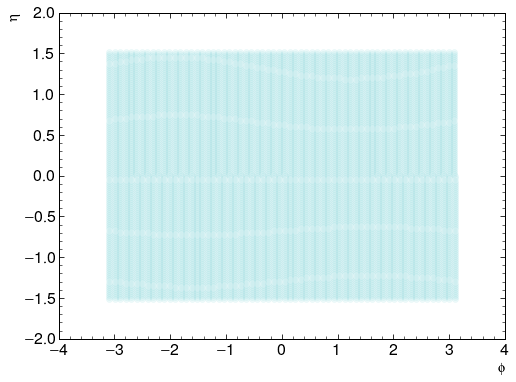

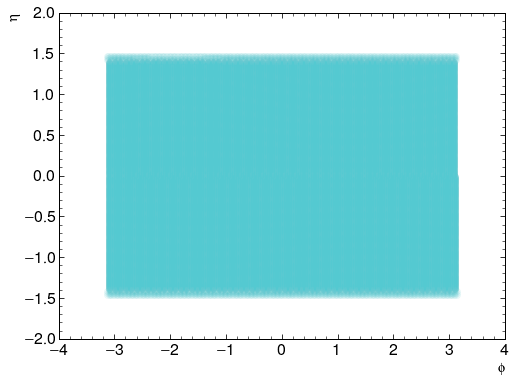

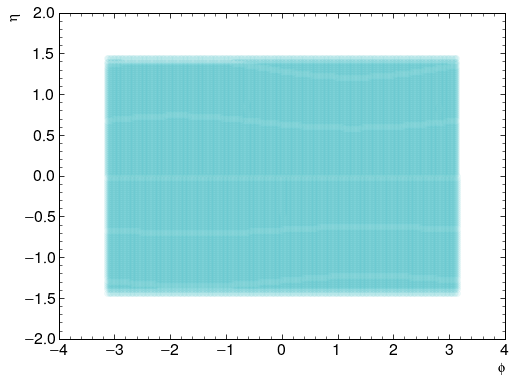

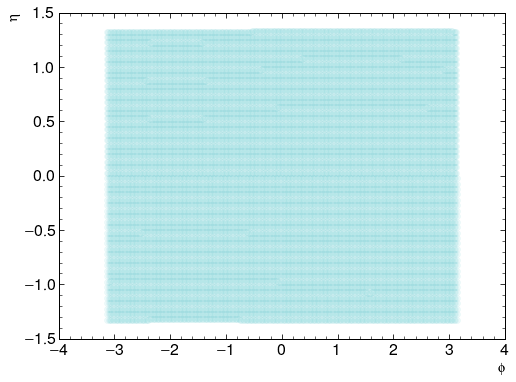

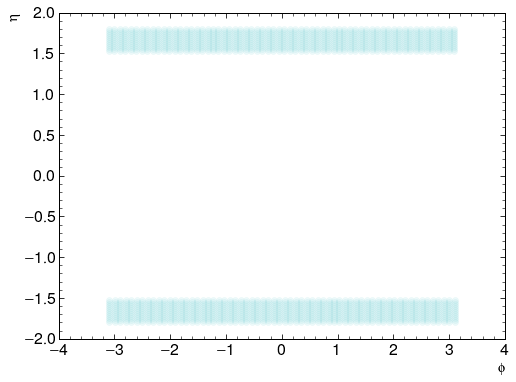

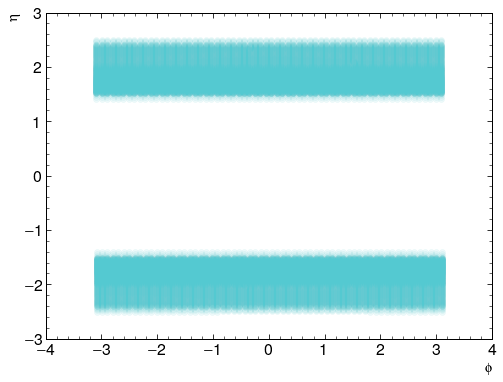

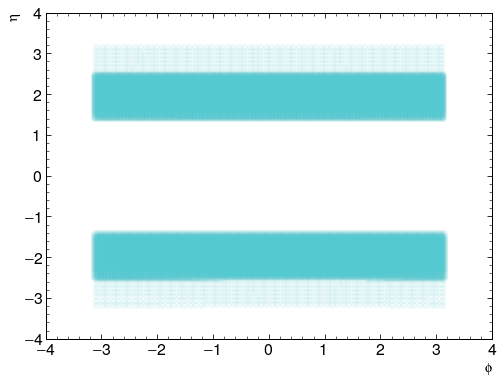

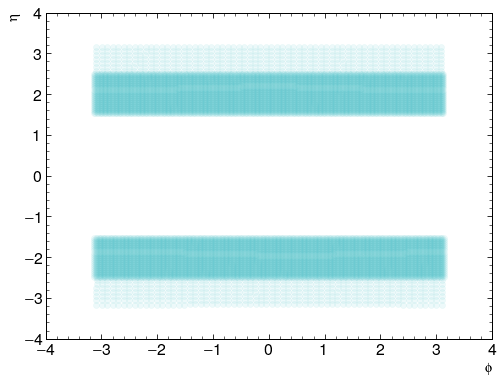

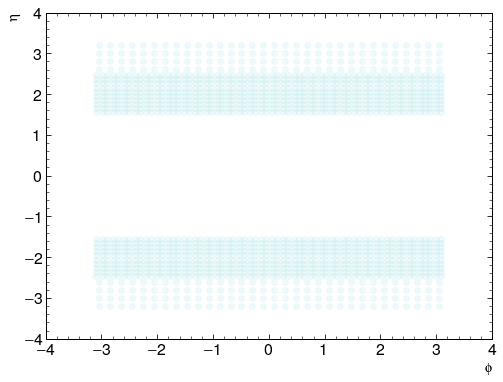

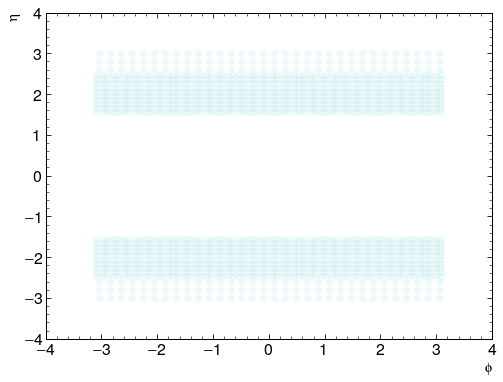

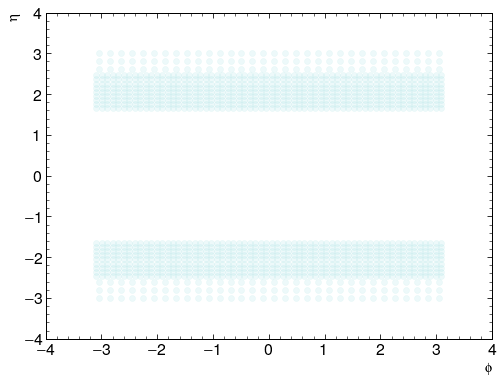

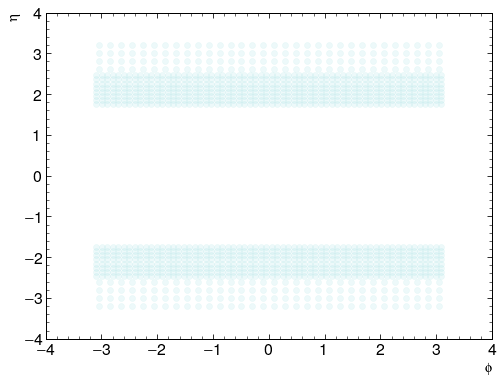

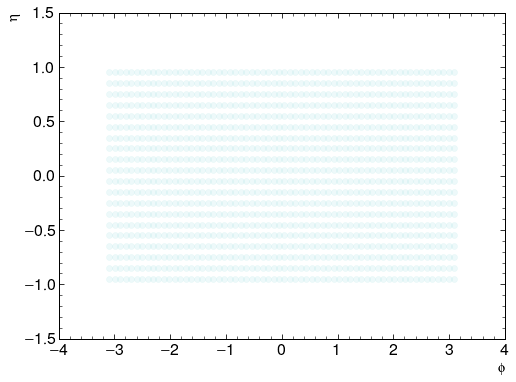

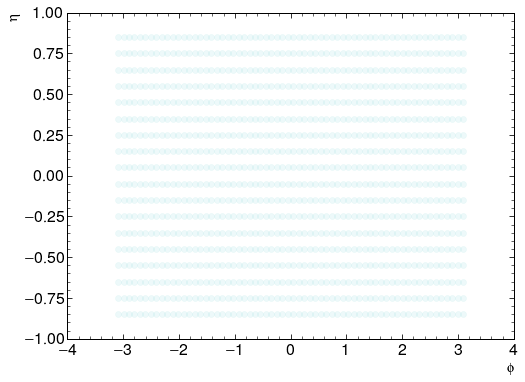

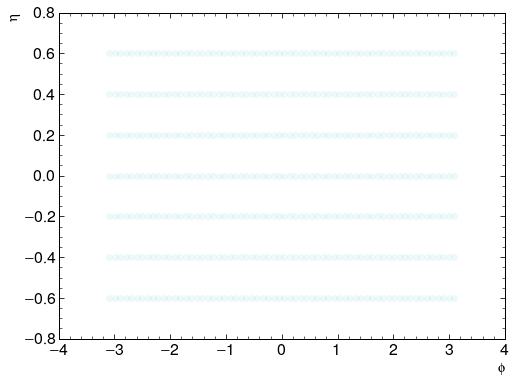

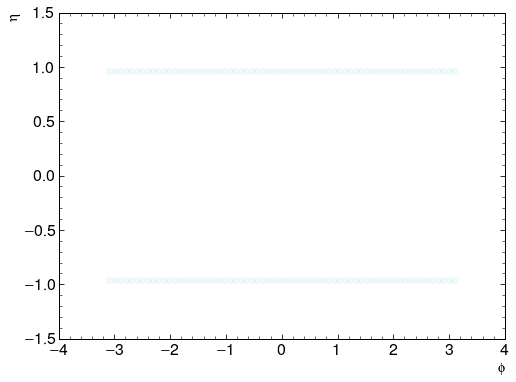

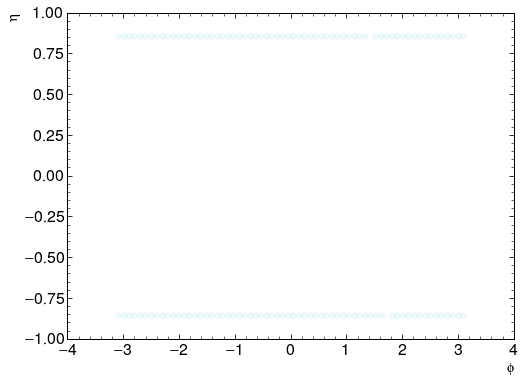

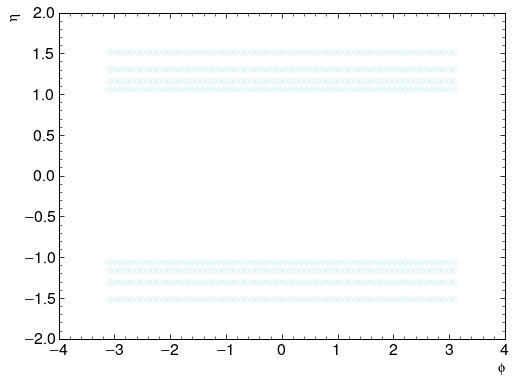

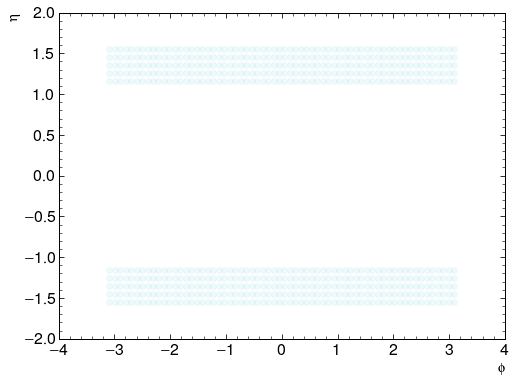

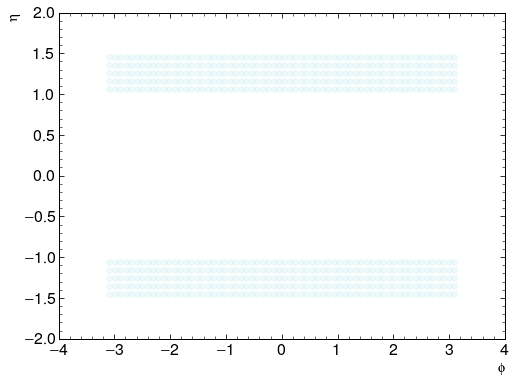

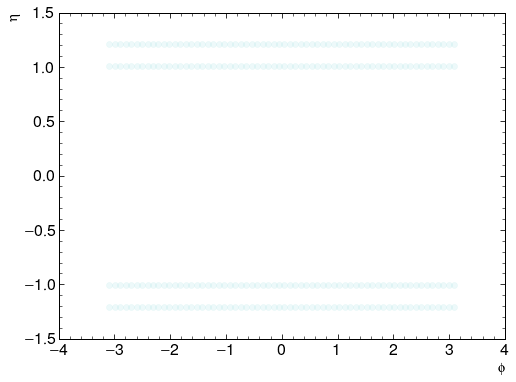

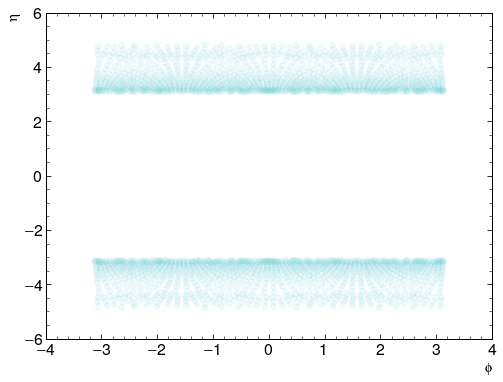

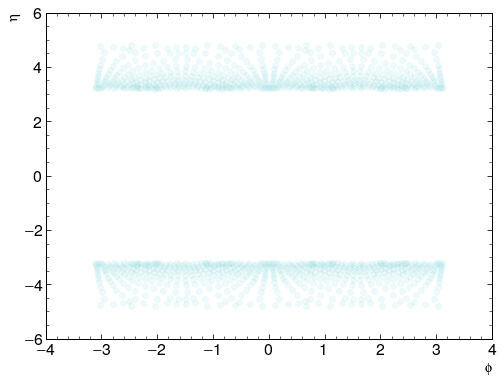

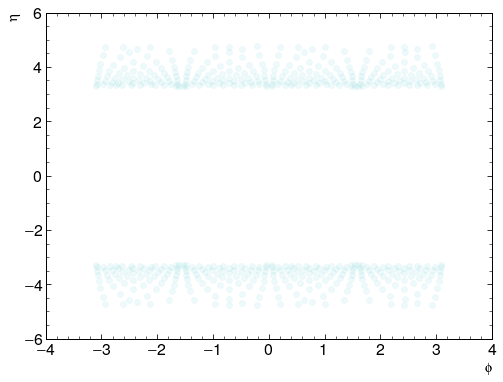

In [19]:
for i in range(24):
    sel = pdata['cell_geo_sampling']==i
    fig = plt.figure()
    plt.scatter(pdata['cell_geo_phi'][sel],pdata['cell_geo_eta'][sel],alpha=0.1)
    ampl.set_xlabel("$\phi$")
    ampl.set_ylabel("$\eta$")
    
plt.close('all')

In [14]:
vals = set(v for v in pdata['cell_geo_sampling'])

In [15]:
vals

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23}

## Convenience Accessor for CellGeo
<div style="text-align: right"> <a href="#Experimentation-with-'graph'-style-inputs">Top</a> </div>

In [5]:
class cell_info:
    meta_tree = 'CellGeo'
    id_branch = 'cell_geo_ID'
    
    def __init__(self, metafile):
        with ur.open(metafile) as ifile:
            self.meta_keys = ifile[self.meta_tree].keys()
            self.celldata = ifile[self.meta_tree].arrays(
                self.meta_keys)
            
        self.id_map = {}
        for i, cell_id in enumerate(self.celldata[self.id_branch][0]):
            self.id_map[cell_id] = i

    def get_cell_info(self, cell_id):
        return {
            k : self.celldata[k][0][self.id_map[cell_id]]
            for k in self.meta_keys
        }
    
    def get_cell_info_vector(self, cell_id):
        res = []
        for k in self.meta_keys:
            if(k == self.id_branch):
                continue
            res.append(self.celldata[k][0][self.id_map[cell_id]])
        return res
    
    def __getitem__(self, key):
        return self.get_cell_info(key)
    

In [6]:
ci = cell_info(inputpath+'single_pion.mltree.root')
# ci = cell_info(inputpath+'pi0-graph.root')

In [ ]:
sampling_layer = {
    0 : 'PreB', 1 : 'EMB1', 2 : 'EMB2', 3 : 'EMB3',
    4 : 'PreE', 5 : 'EME1', 6 : 'EME2', 7 : 'EME3',
    8 : 'HEC0', 9 : 'HEC1', 10 : 'HEC2', 11 : 'HEC3',
    12 : 'TileBar0', 13 : 'TileBar1', 14 : 'TileBar2',
    15 : 'TileGap1', 16 : 'TileGap2', 17 : 'TileGap3',
    18 : 'TileExt0', 19 : 'TileExt1', 20 : 'TileExt2',
    21 : 'FCAL0', 22 : 'FCAL1', 23 : 'FCAL2',
    24 : 'MiniFCAL0', 25 : 'MiniFCAL1', 26 : 'MiniFCAL2', 27 : 'MiniFCAL3',
    28 : 'Unknown'
}

['runNumber', 'eventNumber', 'lumiBlock', 'coreFlags', 'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'NPV', 'actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'weight_pileup', 'correct_mu', 'rand_run_nr', 'rand_lumiblock_nr', 'nTruthPart', 'pdgId', 'status', 'barcode', 'truthPartPt', 'truthPartE', 'truthPartMass', 'truthPartEta', 'truthPartPhi', 'nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta', 'trackPhi', 'trackNumberOfPixelHits', 'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors', 'trackNumberOfSCTDeadSensors', 'trackNumberOfPixelSharedHits', 'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles', 'trackNumberOfSCTHoles', 'trackNumberOfInnermostPixelLayerHits', 'trackNumberOfNextToInnermostPixelLayerHits', 'trackExpectInnermostPixelLayerHit', 'trackExpectNextToInnermostPixelLayerHit', 'trackNumberOfTRTHits', 'trackNumberOfTRTOutliers', 'trackChiSquared', 'trackNumberDOF', 'trackD0', 'trackZ0', 'trackEta_PreSamplerB', 'trackPhi_PreSamplerB', 'trackEt

In [7]:
with ur.open(inputpath+'single_pion.mltree.root') as ifile:
# with ur.open(inputpath+'pi0-graph.root') as ifile:
    entries = ifile['EventTree'].num_entries
    pdata = ifile['EventTree'].arrays(
        ['cluster_cell_ID', 'cluster_cell_E', 'cluster_Eta', 'cluster_Phi'])

In [13]:
import pickle
with open(inputpath+'pi0-graph-data','wb') as ofile:
    pickle.dump(pdata,ofile)

OverflowError: cannot serialize a bytes object larger than 4 GiB

In [31]:
layers = set()
for evt in range(entries):
    print('{}/{}'.format(evt,entries))
    for cluster in pdata['cluster_cell_ID'][evt]:
        layers = layers.union((
            ci[c]['cell_geo_sampling']
            for c in cluster
        ))

0/2000
1/2000
2/2000
3/2000
4/2000
5/2000
6/2000
7/2000
8/2000
9/2000
10/2000
11/2000
12/2000
13/2000
14/2000
15/2000
16/2000
17/2000
18/2000
19/2000
20/2000
21/2000
22/2000
23/2000
24/2000
25/2000
26/2000
27/2000
28/2000
29/2000
30/2000
31/2000
32/2000
33/2000
34/2000
35/2000
36/2000
37/2000
38/2000
39/2000
40/2000
41/2000
42/2000
43/2000
44/2000
45/2000
46/2000
47/2000
48/2000
49/2000
50/2000
51/2000
52/2000
53/2000
54/2000
55/2000
56/2000
57/2000
58/2000
59/2000
60/2000
61/2000
62/2000
63/2000
64/2000
65/2000
66/2000
67/2000
68/2000
69/2000
70/2000
71/2000
72/2000
73/2000
74/2000
75/2000
76/2000
77/2000
78/2000
79/2000
80/2000
81/2000
82/2000
83/2000
84/2000
85/2000
86/2000
87/2000
88/2000
89/2000
90/2000
91/2000
92/2000
93/2000
94/2000
95/2000
96/2000
97/2000
98/2000
99/2000
100/2000
101/2000
102/2000
103/2000
104/2000
105/2000
106/2000
107/2000
108/2000
109/2000
110/2000
111/2000
112/2000
113/2000
114/2000
115/2000
116/2000
117/2000
118/2000
119/2000
120/2000
121/2000
122/2000
123

924/2000
925/2000
926/2000
927/2000
928/2000
929/2000
930/2000
931/2000
932/2000
933/2000
934/2000
935/2000
936/2000
937/2000
938/2000
939/2000
940/2000
941/2000
942/2000
943/2000
944/2000
945/2000
946/2000
947/2000
948/2000
949/2000
950/2000
951/2000
952/2000
953/2000
954/2000
955/2000
956/2000
957/2000
958/2000
959/2000
960/2000
961/2000
962/2000
963/2000
964/2000
965/2000
966/2000
967/2000
968/2000
969/2000
970/2000
971/2000
972/2000
973/2000
974/2000
975/2000
976/2000
977/2000
978/2000
979/2000
980/2000
981/2000
982/2000
983/2000
984/2000
985/2000
986/2000
987/2000
988/2000
989/2000
990/2000
991/2000
992/2000
993/2000
994/2000
995/2000
996/2000
997/2000
998/2000
999/2000
1000/2000
1001/2000
1002/2000
1003/2000
1004/2000
1005/2000
1006/2000
1007/2000
1008/2000
1009/2000
1010/2000
1011/2000
1012/2000
1013/2000
1014/2000
1015/2000
1016/2000
1017/2000
1018/2000
1019/2000
1020/2000
1021/2000
1022/2000
1023/2000
1024/2000
1025/2000
1026/2000
1027/2000
1028/2000
1029/2000
1030/2000
1031/2

1753/2000
1754/2000
1755/2000
1756/2000
1757/2000
1758/2000
1759/2000
1760/2000
1761/2000
1762/2000
1763/2000
1764/2000
1765/2000
1766/2000
1767/2000
1768/2000
1769/2000
1770/2000
1771/2000
1772/2000
1773/2000
1774/2000
1775/2000
1776/2000
1777/2000
1778/2000
1779/2000
1780/2000
1781/2000
1782/2000
1783/2000
1784/2000
1785/2000
1786/2000
1787/2000
1788/2000
1789/2000
1790/2000
1791/2000
1792/2000
1793/2000
1794/2000
1795/2000
1796/2000
1797/2000
1798/2000
1799/2000
1800/2000
1801/2000
1802/2000
1803/2000
1804/2000
1805/2000
1806/2000
1807/2000
1808/2000
1809/2000
1810/2000
1811/2000
1812/2000
1813/2000
1814/2000
1815/2000
1816/2000
1817/2000
1818/2000
1819/2000
1820/2000
1821/2000
1822/2000
1823/2000
1824/2000
1825/2000
1826/2000
1827/2000
1828/2000
1829/2000
1830/2000
1831/2000
1832/2000
1833/2000
1834/2000
1835/2000
1836/2000
1837/2000
1838/2000
1839/2000
1840/2000
1841/2000
1842/2000
1843/2000
1844/2000
1845/2000
1846/2000
1847/2000
1848/2000
1849/2000
1850/2000
1851/2000
1852/2000


In [32]:
layers

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22}

In [26]:
layers0 = set()
for cluster in pdata['cluster_cell_ID'][0]:
    layers0 = layers0.union(set(ci[c]['cell_geo_sampling'] for c in cluster))
print(layers0)

{17, 3, 12, 13}


In [33]:
# generate images for EMB123,TileBar012; ignore other layers for now

old_layers = {
    'names' :["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"],
    'ids' : [1,2,3,12,13,14],
}

In [47]:
pcells = {
    layer : {'eta':[],'phi':[]}#np.zeros((meta['len_eta'],meta['len_phi']))
    for layer,meta in mu.cell_meta.items()
}
for evt in range(entries):
    print('Event {}/2000'.format(evt+1))
    for c_id,c_energy in zip(pdata['cluster_cell_ID'][evt],pdata['cluster_cell_E'][evt]):
        for layer,l_id in zip(old_layers['names'],old_layers['ids']):
#             print('  Layer {}'.format(layer))
            ids = np.array([ci[e]['cell_geo_sampling'] for e in c_id])
            sel = (ids==l_id)
            
            for sel_energy,sel_id in zip(c_energy[sel],c_id[sel]):
                c_info = ci[sel_id]
#                 eta_bin = int(c_info['cell_geo_eta']/c_info['cell_geo_deta'])
#                 phi_bin = int(c_info['cell_geo_phi']/c_info['cell_geo_dphi'])
#                 pcells[layer][eta_bin][phi_bin] += sel_energy
                pcells[layer]['eta'].append(c_info['cell_geo_eta'])
                pcells[layer]['phi'].append(c_info['cell_geo_phi'])

Event 1/2000
Event 2/2000
Event 3/2000
Event 4/2000
Event 5/2000
Event 6/2000
Event 7/2000
Event 8/2000
Event 9/2000
Event 10/2000
Event 11/2000
Event 12/2000
Event 13/2000
Event 14/2000
Event 15/2000
Event 16/2000
Event 17/2000
Event 18/2000
Event 19/2000
Event 20/2000
Event 21/2000
Event 22/2000
Event 23/2000
Event 24/2000
Event 25/2000
Event 26/2000
Event 27/2000
Event 28/2000
Event 29/2000
Event 30/2000
Event 31/2000
Event 32/2000
Event 33/2000
Event 34/2000
Event 35/2000
Event 36/2000
Event 37/2000
Event 38/2000
Event 39/2000
Event 40/2000
Event 41/2000
Event 42/2000
Event 43/2000
Event 44/2000
Event 45/2000
Event 46/2000
Event 47/2000
Event 48/2000
Event 49/2000
Event 50/2000
Event 51/2000
Event 52/2000
Event 53/2000
Event 54/2000
Event 55/2000
Event 56/2000
Event 57/2000
Event 58/2000
Event 59/2000
Event 60/2000
Event 61/2000
Event 62/2000
Event 63/2000
Event 64/2000
Event 65/2000
Event 66/2000
Event 67/2000
Event 68/2000
Event 69/2000
Event 70/2000
Event 71/2000
Event 72/2000
E

Event 555/2000
Event 556/2000
Event 557/2000
Event 558/2000
Event 559/2000
Event 560/2000
Event 561/2000
Event 562/2000
Event 563/2000
Event 564/2000
Event 565/2000
Event 566/2000
Event 567/2000
Event 568/2000
Event 569/2000
Event 570/2000
Event 571/2000
Event 572/2000
Event 573/2000
Event 574/2000
Event 575/2000
Event 576/2000
Event 577/2000
Event 578/2000
Event 579/2000
Event 580/2000
Event 581/2000
Event 582/2000
Event 583/2000
Event 584/2000
Event 585/2000
Event 586/2000
Event 587/2000
Event 588/2000
Event 589/2000
Event 590/2000
Event 591/2000
Event 592/2000
Event 593/2000
Event 594/2000
Event 595/2000
Event 596/2000
Event 597/2000
Event 598/2000
Event 599/2000
Event 600/2000
Event 601/2000
Event 602/2000
Event 603/2000
Event 604/2000
Event 605/2000
Event 606/2000
Event 607/2000
Event 608/2000
Event 609/2000
Event 610/2000
Event 611/2000
Event 612/2000
Event 613/2000
Event 614/2000
Event 615/2000
Event 616/2000
Event 617/2000
Event 618/2000
Event 619/2000
Event 620/2000
Event 621/

Event 1097/2000
Event 1098/2000
Event 1099/2000
Event 1100/2000
Event 1101/2000
Event 1102/2000
Event 1103/2000
Event 1104/2000
Event 1105/2000
Event 1106/2000
Event 1107/2000
Event 1108/2000
Event 1109/2000
Event 1110/2000
Event 1111/2000
Event 1112/2000
Event 1113/2000
Event 1114/2000
Event 1115/2000
Event 1116/2000
Event 1117/2000
Event 1118/2000
Event 1119/2000
Event 1120/2000
Event 1121/2000
Event 1122/2000
Event 1123/2000
Event 1124/2000
Event 1125/2000
Event 1126/2000
Event 1127/2000
Event 1128/2000
Event 1129/2000
Event 1130/2000
Event 1131/2000
Event 1132/2000
Event 1133/2000
Event 1134/2000
Event 1135/2000
Event 1136/2000
Event 1137/2000
Event 1138/2000
Event 1139/2000
Event 1140/2000
Event 1141/2000
Event 1142/2000
Event 1143/2000
Event 1144/2000
Event 1145/2000
Event 1146/2000
Event 1147/2000
Event 1148/2000
Event 1149/2000
Event 1150/2000
Event 1151/2000
Event 1152/2000
Event 1153/2000
Event 1154/2000
Event 1155/2000
Event 1156/2000
Event 1157/2000
Event 1158/2000
Event 11

Event 1610/2000
Event 1611/2000
Event 1612/2000
Event 1613/2000
Event 1614/2000
Event 1615/2000
Event 1616/2000
Event 1617/2000
Event 1618/2000
Event 1619/2000
Event 1620/2000
Event 1621/2000
Event 1622/2000
Event 1623/2000
Event 1624/2000
Event 1625/2000
Event 1626/2000
Event 1627/2000
Event 1628/2000
Event 1629/2000
Event 1630/2000
Event 1631/2000
Event 1632/2000
Event 1633/2000
Event 1634/2000
Event 1635/2000
Event 1636/2000
Event 1637/2000
Event 1638/2000
Event 1639/2000
Event 1640/2000
Event 1641/2000
Event 1642/2000
Event 1643/2000
Event 1644/2000
Event 1645/2000
Event 1646/2000
Event 1647/2000
Event 1648/2000
Event 1649/2000
Event 1650/2000
Event 1651/2000
Event 1652/2000
Event 1653/2000
Event 1654/2000
Event 1655/2000
Event 1656/2000
Event 1657/2000
Event 1658/2000
Event 1659/2000
Event 1660/2000
Event 1661/2000
Event 1662/2000
Event 1663/2000
Event 1664/2000
Event 1665/2000
Event 1666/2000
Event 1667/2000
Event 1668/2000
Event 1669/2000
Event 1670/2000
Event 1671/2000
Event 16

EMB1
 -1.4632099866867065 1.46561598777771
 -3.1297616958618164 3.1289010047912598
EMB2
 -1.4386658668518066 1.4407954216003418
 -3.130122423171997 3.133882999420166
EMB3
 -1.3256614208221436 1.3277251720428467
 -3.130340337753296 3.1337225437164307
TileBar0
 -0.949999988079071 0.949999988079071
 -3.0925052165985107 3.09250545501709
TileBar1
 -0.8500000238418579 0.8500000238418579
 -3.0925052165985107 3.09250545501709
TileBar2
 -0.6000000238418579 0.6000000238418579
 -3.0925052165985107 3.09250545501709


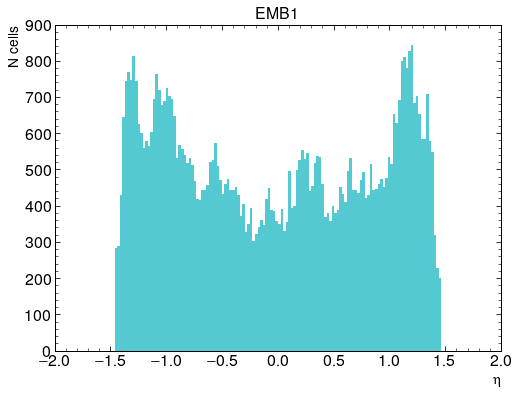

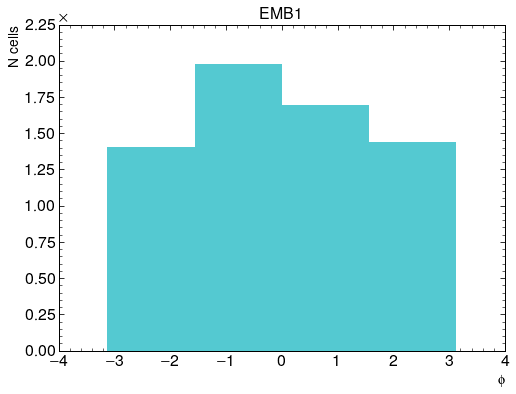

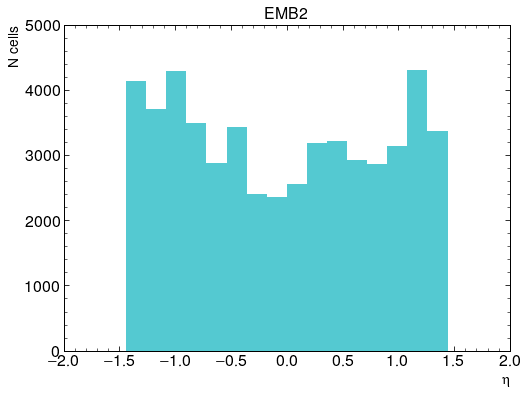

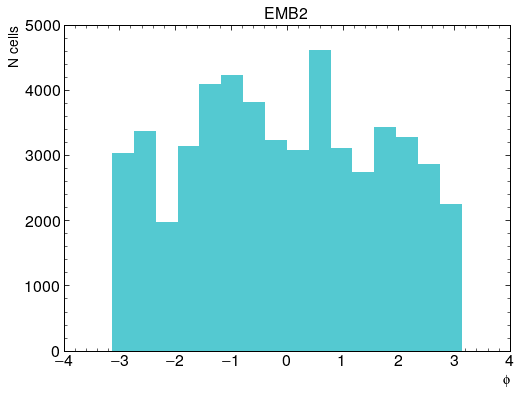

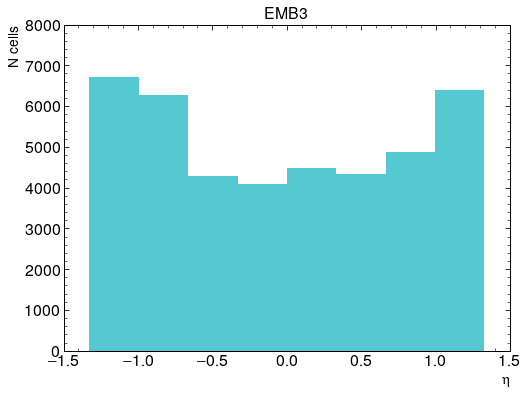

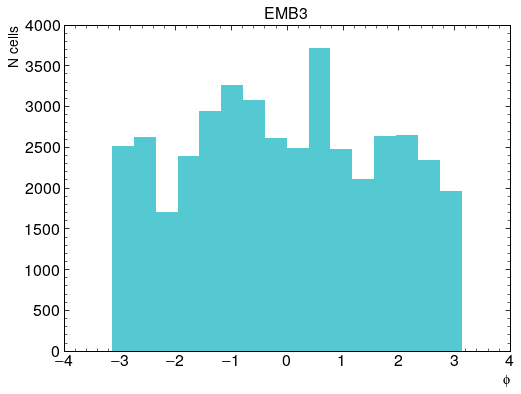

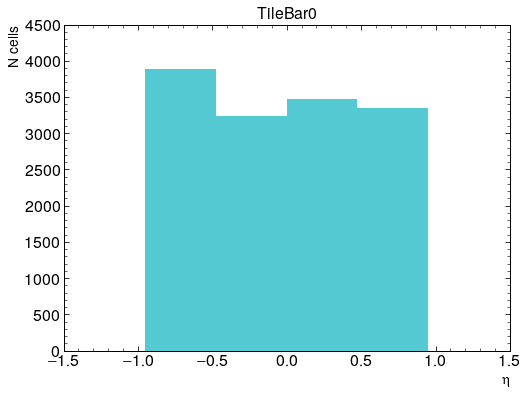

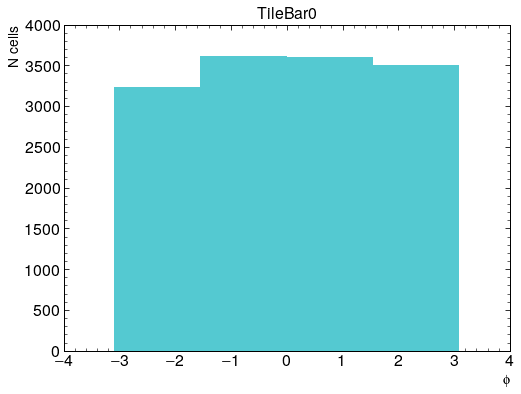

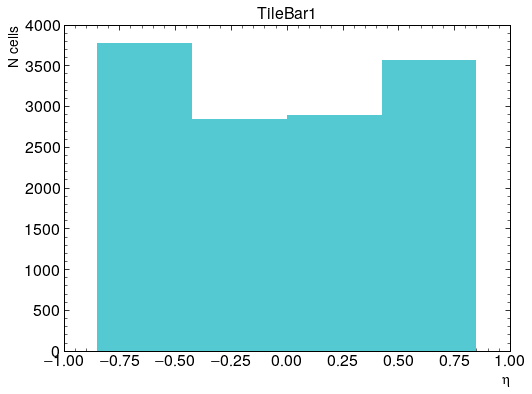

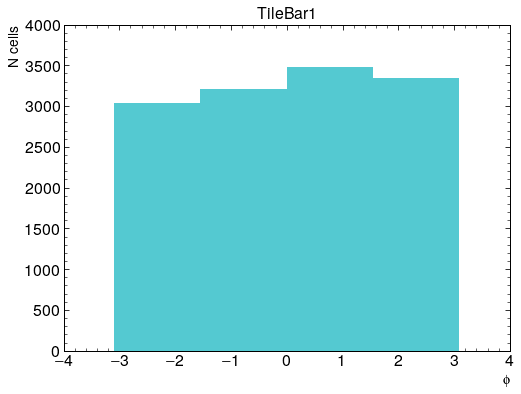

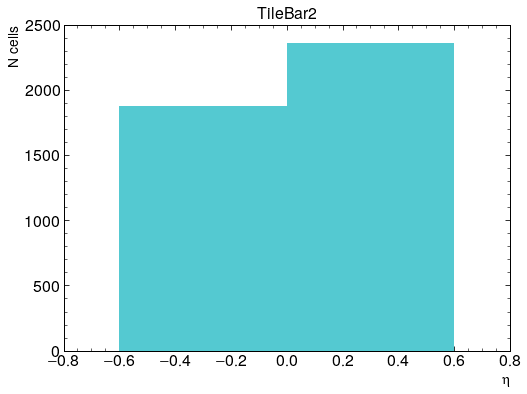

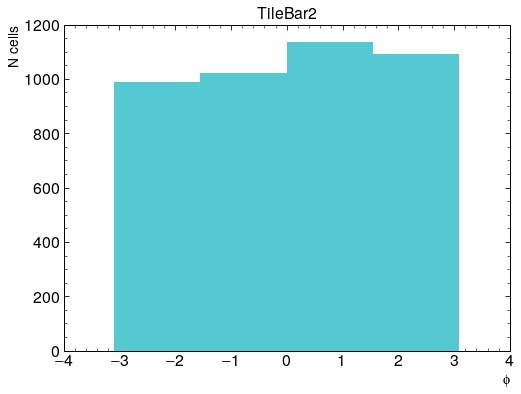

In [68]:
bins = {'eta':{},'phi':{}}
for layer,data in pcells.items():
    fig = plt.figure()
    (_,bins['eta'][layer],_) = plt.hist(data['eta'], bins=mu.cell_meta[layer]['len_eta'])
    ampl.set_xlabel("$\eta$")
    ampl.set_ylabel("N cells")
    plt.title(layer)
    plt.savefig(plotpath+layer+'_eta'+'.pdf')
    
    fig = plt.figure()
    (_,bins['phi'][layer],_) = plt.hist(data['phi'], bins=mu.cell_meta[layer]['len_phi'])
    ampl.set_xlabel("$\phi$")
    ampl.set_ylabel("N cells")
    plt.title(layer)
    plt.savefig(plotpath+layer+'_phi'+'.pdf')
    
    print(layer)
    print('',min(data['eta']),max(data['eta']))
    print('',min(data['phi']),max(data['phi']))

In [69]:
bins['eta']

{'EMB1': array([-1.46320999e+00, -1.44032853e+00, -1.41744708e+00, -1.39456563e+00,
        -1.37168417e+00, -1.34880272e+00, -1.32592127e+00, -1.30303982e+00,
        -1.28015836e+00, -1.25727691e+00, -1.23439546e+00, -1.21151400e+00,
        -1.18863255e+00, -1.16575110e+00, -1.14286965e+00, -1.11998819e+00,
        -1.09710674e+00, -1.07422529e+00, -1.05134383e+00, -1.02846238e+00,
        -1.00558093e+00, -9.82699475e-01, -9.59818022e-01, -9.36936569e-01,
        -9.14055116e-01, -8.91173664e-01, -8.68292211e-01, -8.45410758e-01,
        -8.22529305e-01, -7.99647852e-01, -7.76766399e-01, -7.53884946e-01,
        -7.31003493e-01, -7.08122040e-01, -6.85240587e-01, -6.62359134e-01,
        -6.39477681e-01, -6.16596228e-01, -5.93714776e-01, -5.70833323e-01,
        -5.47951870e-01, -5.25070417e-01, -5.02188964e-01, -4.79307511e-01,
        -4.56426058e-01, -4.33544605e-01, -4.10663152e-01, -3.87781699e-01,
        -3.64900246e-01, -3.42018793e-01, -3.19137340e-01, -2.96255887e-01,
    

In [58]:
import pickle
with open(inputpath+'cell_geo.pickle','wb') as ofile:
    pickle.dump(pcells,ofile)

In [59]:
import pickle
with open(inputpath+'cell_geo.pickle','rb') as ifile:
    pcells = pickle.load(ifile)

In [7]:
pcells = {
    layer : {'eta':[],'phi':[]}#np.zeros((meta['len_eta'],meta['len_phi']))
    for layer,meta in mu.cell_meta.items()
}
with ur.open(inputpath+'single_pion.mltree.root') as ifile:
    entries = ifile['EventTree'].num_entries
    for evt in range(entries):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-7-726d1abba0e7>, line 8)

In [50]:
sel = np.array([(i in old_layers['ids']) for i in ids])

In [72]:
ci[pdata['cluster_cell_ID'][0][0][1]]

{'cell_geo_ID': 1149470720,
 'cell_geo_sampling': 12,
 'cell_geo_eta': 0.85,
 'cell_geo_phi': 1.4235342,
 'cell_geo_rPerp': 2450.0,
 'cell_geo_deta': 0.1,
 'cell_geo_dphi': 0.09817477,
 'cell_geo_volume': 24392260.0,
 'cell_geo_sigma': 22.489023}

In [66]:
for l,a in pcells.items():
    print(a.shape)

(128, 4)
(16, 16)
(8, 16)
(4, 4)
(4, 4)
(2, 4)


In [138]:
ifile = ur.open(inputpath+'single_pion.mltree.root')

In [ ]:
ifile['EventTree']['cluster_cell_ID'].num_entries

In [9]:
layer_bins = {
    'EMB1' : {
         'eta_min':-1.4632099866867065, 'eta_max':1.46561598777771,
         'phi_min':-3.1297616958618164, 'phi_max': 3.1289010047912598
    },
    'EMB2' : {
         'eta_min':-1.4386658668518066, 'eta_max':1.4407954216003418,
         'phi_min':-3.130122423171997, 'phi_max':3.133882999420166
    },
    'EMB3' : {
         'eta_min':-1.3256614208221436, 'eta_max':1.3277251720428467,
         'phi_min':-3.130340337753296, 'phi_max':3.1337225437164307
    },
    'TileBar0' : {
         'eta_min':-0.949999988079071, 'eta_max':0.949999988079071,
         'phi_min':-3.0925052165985107, 'phi_max':3.09250545501709
    },
    'TileBar1' : {
         'eta_min':-0.8500000238418579, 'eta_max':0.8500000238418579,
         'phi_min':-3.0925052165985107, 'phi_max':3.09250545501709
    },
    'TileBar2' : {
         'eta_min':-0.6000000238418579, 'eta_max':0.6000000238418579,
         'phi_min':-3.0925052165985107, 'phi_max':3.09250545501709
    }
}
for layer in layer_bins:
    layer_bins[layer]['phi_range'] = layer_bins[layer]['phi_max'] - layer_bins[layer]['phi_min']
    layer_bins[layer]['eta_range'] = layer_bins[layer]['eta_max'] - layer_bins[layer]['eta_min']

In [10]:
entries

9999000

## 'Average' Image Generation
<div style="text-align: right"> <a href="#Experimentation-with-'graph'-style-inputs">Top</a> </div>

In [44]:
pcells = {
    layer : np.zeros((meta['len_eta'],meta['len_phi']))
    for layer,meta in mu.cell_meta.items()
}
sampling_layers = {
    1 : 'EMB1', 2 : 'EMB2', 3 : 'EMB3',
    12 : 'TileBar0', 13 : 'TileBar1', 14 : 'TileBar2',
}
for evt in range(entries):
# for evt in range(2000):
    if((evt+1)%100==0):
        print('Event {}/2000'.format(evt+1))
    for clus in range(len(pdata['cluster_cell_ID'][evt])):
        for c_id,c_energy in zip(pdata['cluster_cell_ID'][evt][clus],pdata['cluster_cell_E'][evt][clus]):
            c_info = ci[c_id]
            if c_info['cell_geo_sampling'] in sampling_layers:
                layer = sampling_layers[c_info['cell_geo_sampling']]
                c_eta,c_phi = pdata['cluster_Eta'][evt][clus],pdata['cluster_Phi'][evt][clus]
                eta_bin = int(((c_info['cell_geo_eta']-c_eta-deta['min'])*mu.cell_meta[layer]['len_eta']/deta['range']))
                phi_bin = int(((c_info['cell_geo_phi']-c_phi-dphi['min'])*mu.cell_meta[layer]['len_phi']/dphi['range']))
                if(eta_bin<0 or
                   eta_bin>=mu.cell_meta[layer]['len_eta'] or
                   phi_bin<0 or
                   phi_bin>=mu.cell_meta[layer]['len_phi']):
#                     print(c_id,c_info['cell_geo_sampling'],layer,c_info['cell_geo_eta']-c_eta,c_info['cell_geo_phi']-c_phi)
                    continue
#                 print(c_id,c_info['cell_geo_sampling'],layer,c_info['cell_geo_eta']-c_eta,c_info['cell_geo_phi']-c_phi)
                pcells[layer][eta_bin][phi_bin] += c_energy/entries

# redo - id map wrong somehow?
# for evt in range(entries):
#     print('Event {}/2000'.format(evt+1))
#     for c_id,c_energy in zip(pdata['cluster_cell_ID'][evt],pdata['cluster_cell_E'][evt]):
#         for layer,l_id in zip(old_layers['names'],old_layers['ids']):
# #             print('  Layer {}'.format(layer))
#             ids = np.array([ci[e]['cell_geo_sampling'] for e in c_id])
#             sel = (ids==l_id)
            
#             for sel_energy,sel_id in zip(c_energy[sel],c_id[sel]):
#                 c_info = ci[sel_id]
#                 eta_bin = int((c_info['cell_geo_eta']-layer_bins[layer]['eta_min'])*(mu.cell_meta[layer]['len_eta']-1)/layer_bins[layer]['eta_range'])
#                 phi_bin = int((c_info['cell_geo_phi']-layer_bins[layer]['phi_min'])*(mu.cell_meta[layer]['len_phi']-1)/layer_bins[layer]['phi_range'])
#                 print(layer,c_info['cell_geo_eta'],c_info['cell_geo_phi'])
#                 print(eta_bin,phi_bin)
#                 pcells[layer][evt][phi_bin][eta_bin] += sel_energy

Event 100/2000
Event 200/2000
Event 300/2000
Event 400/2000
Event 500/2000
Event 600/2000
Event 700/2000
Event 800/2000
Event 900/2000
Event 1000/2000
Event 1100/2000
Event 1200/2000
Event 1300/2000
Event 1400/2000
Event 1500/2000
Event 1600/2000
Event 1700/2000
Event 1800/2000
Event 1900/2000
Event 2000/2000


In [ ]:
import pickle
with open(inputpath+'reconstructed_images.pickle','wb') as ofile:
    pickle.dump(pcells,ofile)

(128, 4)


<Figure size 576x432 with 0 Axes>

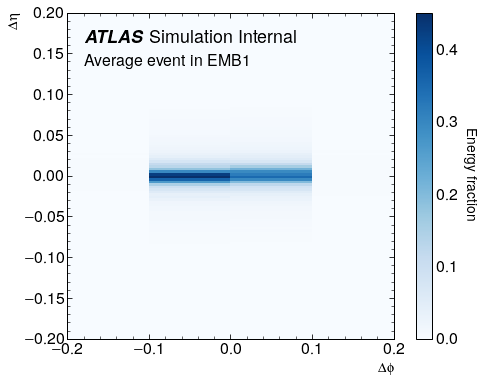

(16, 16)


<Figure size 576x432 with 0 Axes>

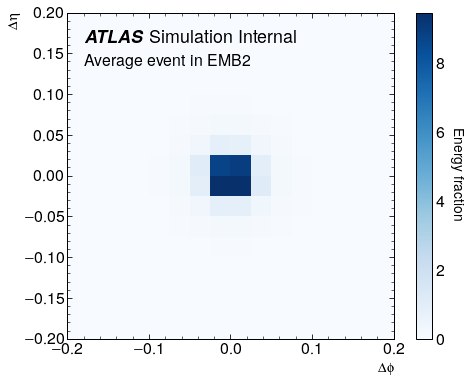

(8, 16)


<Figure size 576x432 with 0 Axes>

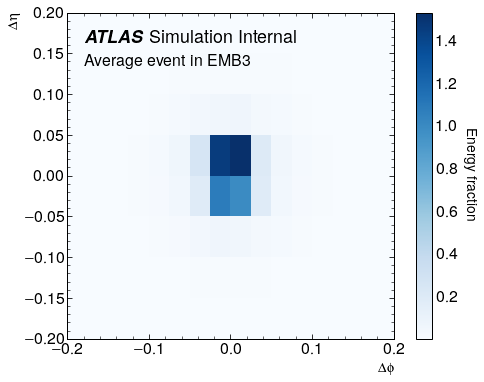

(4, 4)


<Figure size 576x432 with 0 Axes>

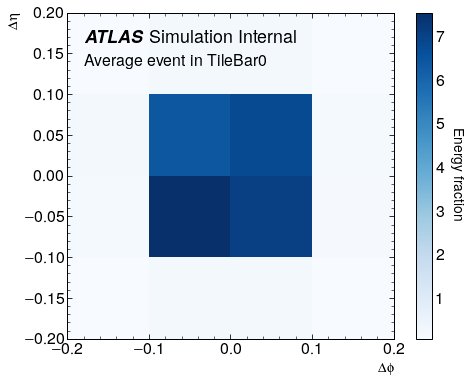

(4, 4)


<Figure size 576x432 with 0 Axes>

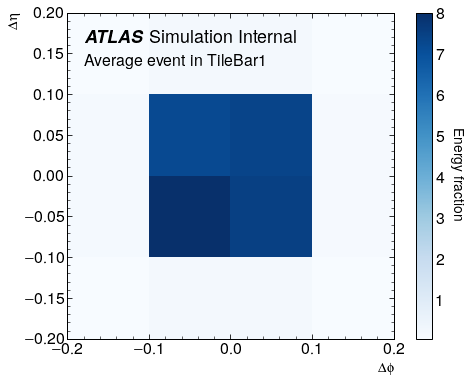

(2, 4)


<Figure size 576x432 with 0 Axes>

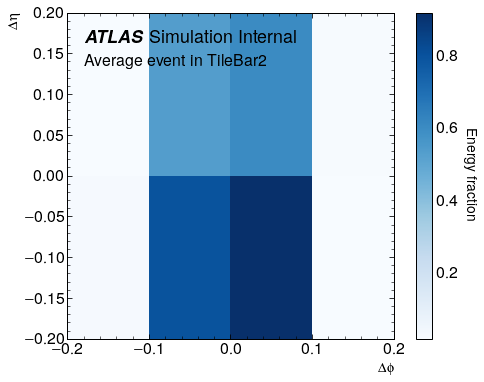

In [45]:
for i in range(1):
    for layer, data in pcells.items():
        print(data.shape)
        plt.cla(); plt.clf()
        fig = plt.figure()
        fig.patch.set_facecolor('white')

        plt.imshow(data, extent=[-0.2, 0.2, -0.2, 0.2],
            cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
        ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
        fig.axes[0].text(-0.18, 0.135, 'Average event in '+layer)
        cbar = plt.colorbar()
        cbar.set_label('Energy fraction', rotation=270, labelpad=20)

        plt.savefig(plotpath+'average_'+layer+'.pdf')
        plt.show()

In [10]:
sampling_layers = {
    1 : 'EMB1', 2 : 'EMB2', 3 : 'EMB3',
    12 : 'TileBar0', 13 : 'TileBar1', 14 : 'TileBar2',
}
pcells = {
    layer : {'eta':[],'phi':[]}#np.zeros((meta['len_eta'],meta['len_phi']))
    for layer,meta in mu.cell_meta.items()
}
for eta,phi,layer,cid in zip(ci.celldata['cell_geo_eta'][0],ci.celldata['cell_geo_phi'][0],ci.celldata['cell_geo_sampling'][0],ci.celldata['cell_geo_ID'][0]):
    if(cid==1149503744):
        print('found')
    if layer in sampling_layers:
        lname = sampling_layers[layer]
        pcells[lname]['eta'].append(eta)
        pcells[lname]['phi'].append(phi)
        if(cid==1149503744):
            print('found')

found
found


In [12]:
pcells['EMB1']['eta']

[-0.0028089177794754505,
 -0.002809362020343542,
 -0.002809799974784255,
 -0.0028102274518460035,
 -0.002810640260577202,
 -0.002811034210026264,
 -0.002811405574902892,
 -0.002811750862747431,
 -0.0028120665811002254,
 -0.002812349935993552,
 -0.0028125979006290436,
 -0.0028128079138696194,
 -0.002812978345900774,
 -0.0028131071012467146,
 -0.0028131932485848665,
 -0.002813235856592655,
 -0.0028132344596087933,
 -0.0028131892904639244,
 -0.0028131003491580486,
 -0.002812968799844384,
 -0.002812796039506793,
 -0.002812583465129137,
 -0.002812333172187209,
 -0.002812047954648733,
 -0.0028117301408201456,
 -0.0028113832231611013,
 -0.002811010228469968,
 -0.0028106148820370436,
 -0.0028102011419832706,
 -0.002809772966429591,
 -0.0028093343134969473,
 -0.002808889839798212,
 -0.002808443270623684,
 -0.0028079994954168797,
 -0.0028075622394680977,
 -0.002807136159390211,
 -0.0028067249804735184,
 -0.0028063326608389616,
 -0.0028059633914381266,
 -0.0028056201990693808,
 -0.002805306576192

In [13]:
for layer,data in pcells.items():
    eta_min, eta_max, phi_min, phi_max = 0,0,0,0
    for i in range(len(data['eta'])):
        if(data['eta'][i]<eta_min):
            eta_min = data['eta'][i]
        if(data['eta'][i]>eta_max):
            eta_max = data['eta'][i]
        if(data['phi'][i]>phi_min):
            phi_min = data['phi'][i]
        if(data['phi'][i]>phi_max):
            phi_max = data['phi'][i]
    print(layer)
    print('',eta_min,eta_max)
    print('',phi_min,phi_max)

EMB1
 -1.4632107019424438 1.46561598777771
 3.1340370178222656 3.1340370178222656
EMB2
 -1.4386658668518066 1.4407954216003418
 3.1338937282562256 3.1338937282562256
EMB3
 -1.3256614208221436 1.3277251720428467
 3.1337225437164307 3.1337225437164307
TileBar0
 -0.949999988079071 0.949999988079071
 3.09250545501709 3.09250545501709
TileBar1
 -0.8500000238418579 0.8500000238418579
 3.09250545501709 3.09250545501709
TileBar2
 -0.6000000238418579 0.6000000238418579
 3.09250545501709 3.09250545501709


## Validation on Single Clusters
<div style="text-align: right"> <a href="#Experimentation-with-'graph'-style-inputs">Top</a> </div>

In [16]:
pdata['cluster_Eta'][0]

<Array [0.871] type='1 * float32'>

In [30]:
# Method 1: calculate bin directly
deta = {
    'min':-0.2,'max':0.2,'range':0.4
}
dphi = {
    'min':-0.2,'max':0.2,'range':0.4
}
pcells = {
    layer : np.zeros((meta['len_eta'],meta['len_phi']))
    for layer,meta in mu.cell_meta.items()
}
sampling_layers = {
    1 : 'EMB1', 2 : 'EMB2', 3 : 'EMB3',
    12 : 'TileBar0', 13 : 'TileBar1', 14 : 'TileBar2',
}
evt = 20#26
clus = 0
for c_id,c_energy in zip(pdata['cluster_cell_ID'][evt][clus],pdata['cluster_cell_E'][evt][clus]):
    c_info = ci[c_id]
    if c_info['cell_geo_sampling'] in sampling_layers:
        layer = sampling_layers[c_info['cell_geo_sampling']]
        c_eta,c_phi = pdata['cluster_Eta'][evt][clus],pdata['cluster_Phi'][evt][clus]
#         eta_bin = int((c_info['cell_geo_eta']-layer_bins[layer]['eta_min'])*(mu.cell_meta[layer]['len_eta'])/layer_bins[layer]['eta_range'])-1
#         phi_bin = int((c_info['cell_geo_phi']-layer_bins[layer]['phi_min'])*(mu.cell_meta[layer]['len_phi'])/layer_bins[layer]['phi_range'])-1
        eta_bin = int(((c_info['cell_geo_eta']-c_eta-deta['min'])*mu.cell_meta[layer]['len_eta']/deta['range']))
        phi_bin = int(((c_info['cell_geo_phi']-c_phi-dphi['min'])*mu.cell_meta[layer]['len_phi']/dphi['range']))
#         if(eta_bin>=mu.cell_meta[layer]['len_eta']):
#             eta_bin = mu.cell_meta[layer]['len_eta']-1
#         if(phi_bin>=mu.cell_meta[layer]['len_phi']):
#             phi_bin = mu.cell_meta[layer]['len_phi']-1
        print(c_id,layer,c_info['cell_geo_eta'],c_info['cell_geo_phi'])
        print(eta_bin,phi_bin,c_energy)
        pcells[layer][eta_bin][phi_bin] += c_energy

759173060 EMB2 -0.18572074174880981 -0.7220381498336792
7 8 41.78080749511719
759173058 EMB2 -0.18571600317955017 -0.7465584874153137
7 7 8.823821067810059
759173062 EMB2 -0.185725599527359 -0.6975172162055969
7 9 5.186136245727539
759172548 EMB2 -0.16073451936244965 -0.7220382690429688
8 8 32.6619758605957
759173572 EMB2 -0.2107081115245819 -0.7220380902290344
6 8 2.211289882659912
759172546 EMB2 -0.16073039174079895 -0.7465585470199585
8 7 14.424948692321777
759173570 EMB2 -0.21070273220539093 -0.746558427810669
6 7 1.0181180238723755
759172550 EMB2 -0.1607387363910675 -0.6975172758102417
8 9 3.0619938373565674
759173574 EMB2 -0.21071359515190125 -0.6975171566009521
6 9 1.1578726768493652
757100656 EMB1 -0.17452508211135864 -0.7344449758529663
63 2 8.555818557739258
757101168 EMB1 -0.17764781415462494 -0.7344449758529663
62 2 3.803330183029175
757101680 EMB1 -0.18077056109905243 -0.7344449758529663
61 2 3.0167016983032227
757102192 EMB1 -0.1838933378458023 -0.7344449758529663
60 2 2.

IndexError: index 4 is out of bounds for axis 0 with size 4

(128, 4)


<Figure size 576x432 with 0 Axes>

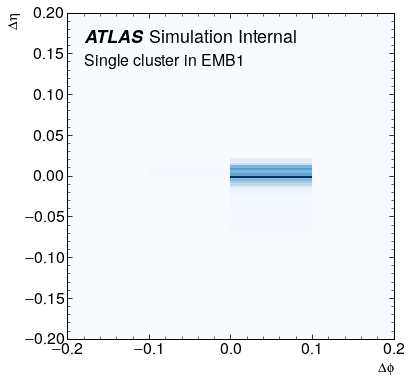

(16, 16)


<Figure size 576x432 with 0 Axes>

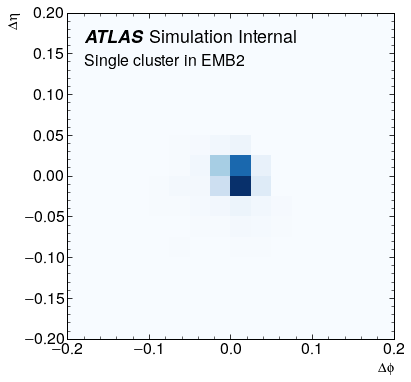

(8, 16)


<Figure size 576x432 with 0 Axes>

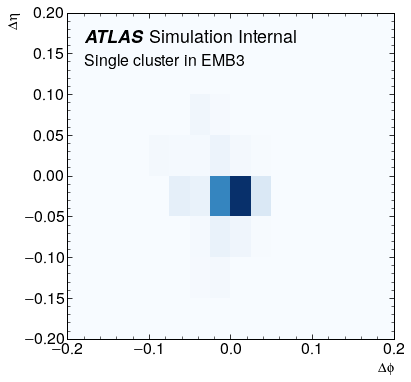

(4, 4)


<Figure size 576x432 with 0 Axes>

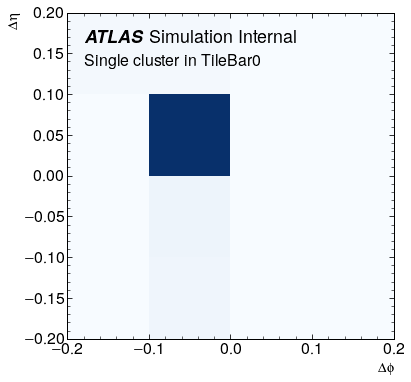

(4, 4)


<Figure size 576x432 with 0 Axes>

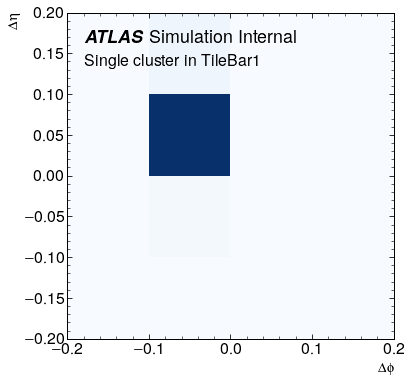

(2, 4)


<Figure size 576x432 with 0 Axes>

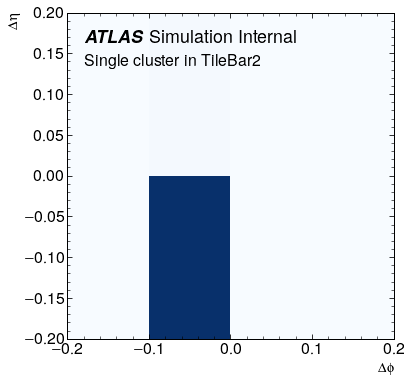

In [31]:
for layer, data in pcells.items():
    print(data.shape)
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.imshow(data, extent=[-0.2, 0.2, -0.2, 0.2],
        cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    ampl.set_xlabel("$\Delta\phi$")
    ampl.set_ylabel("$\Delta\eta$")
    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
    fig.axes[0].text(-0.18, 0.135, 'Single cluster in '+layer)

    plt.savefig(plotpath+'average_'+layer+'.pdf')
    plt.show()

In [12]:
# Method 2: loop through bin boundaries and compare against each
# eta_bins = {
#     layer: np.linspace(layer_bins[layer]['eta_min'],layer_bins[layer]['eta_max'],meta['len_eta'])
#     for layer,meta in mu.cell_meta.items()
# }
# phi_bins = {
#     layer: np.linspace(layer_bins[layer]['phi_min'],layer_bins[layer]['phi_max'],meta['len_phi'])
#     for layer,meta in mu.cell_meta.items()
# }
eta_bins = {
    layer: np.linspace(-0.2,0.2,meta['len_eta'])
    for layer,meta in mu.cell_meta.items()
}
phi_bins = {
    layer: np.linspace(-0.2,0.2,meta['len_phi'])
    for layer,meta in mu.cell_meta.items()
}

pcells = {
    layer : np.zeros((meta['len_eta'],meta['len_phi']))
    for layer,meta in mu.cell_meta.items()
}
sampling_layers = {
    1 : 'EMB1', 2 : 'EMB2', 3 : 'EMB3',
    12 : 'TileBar0', 13 : 'TileBar1', 14 : 'TileBar2',
}
evt = 20#26
clus = 0
for c_id,c_energy in zip(pdata['cluster_cell_ID'][evt][clus],pdata['cluster_cell_E'][evt][clus]):
    c_info = ci[c_id]
    if c_info['cell_geo_sampling'] in sampling_layers:
        layer = sampling_layers[c_info['cell_geo_sampling']]
        eta_bin,phi_bin = len(eta_bins[layer])-1,len(phi_bins[layer])-1
        deta = c_info['cell_geo_eta']-pdata['cluster_Eta'][evt][clus]
        dphi = c_info['cell_geo_phi']-pdata['cluster_Phi'][evt][clus]
        for ibin in range(len(eta_bins[layer])):
#             if(c_info['cell_geo_eta']<=eta_bins[layer][ibin]):
            if(deta<=eta_bins[layer][ibin]):
                eta_bin = ibin
#                 print('eta',ibin,eta_bins[layer][ibin])
                break
                
        for ibin in range(len(phi_bins[layer])):
#             if(c_info['cell_geo_phi']<=phi_bins[layer][ibin]):
            if(dphi<=phi_bins[layer][ibin]):
                phi_bin = ibin
#                 print('phi',ibin,phi_bins[layer][ibin])
                break
        print(c_id,layer,c_info['cell_geo_eta'],c_info['cell_geo_phi'])
        print(eta_bin,phi_bin,c_energy)
        pcells[layer][eta_bin][phi_bin] += c_energy

759173060 EMB2 -0.18572074174880981 -0.7220381498336792
7 9 41.78080749511719
759173058 EMB2 -0.18571600317955017 -0.7465584874153137
7 8 8.823821067810059
759173062 EMB2 -0.185725599527359 -0.6975172162055969
7 9 5.186136245727539
759172548 EMB2 -0.16073451936244965 -0.7220382690429688
8 9 32.6619758605957
759173572 EMB2 -0.2107081115245819 -0.7220380902290344
7 9 2.211289882659912
759172546 EMB2 -0.16073039174079895 -0.7465585470199585
8 8 14.424948692321777
759173570 EMB2 -0.21070273220539093 -0.746558427810669
7 8 1.0181180238723755
759172550 EMB2 -0.1607387363910675 -0.6975172758102417
8 9 3.0619938373565674
759173574 EMB2 -0.21071359515190125 -0.6975171566009521
7 9 1.1578726768493652
757100656 EMB1 -0.17452508211135864 -0.7344449758529663
63 2 8.555818557739258
757101168 EMB1 -0.17764781415462494 -0.7344449758529663
62 2 3.803330183029175
757101680 EMB1 -0.18077056109905243 -0.7344449758529663
61 2 3.0167016983032227
757102192 EMB1 -0.1838933378458023 -0.7344449758529663
60 2 2.

3 3 0.02582712285220623
1141768192 TileBar0 -0.05000000074505806 -0.736310601234436
3 2 0.1490596979856491
759171524 EMB2 -0.11076556891202927 -0.7220383286476135
10 9 0.5691887736320496
759171522 EMB2 -0.11076271533966064 -0.7465586066246033
10 8 0.30750900506973267
759171520 EMB2 -0.1107599213719368 -0.77107834815979
10 7 0.2870943248271942
759173578 EMB2 -0.21072492003440857 -0.6484732031822205
7 11 0.1779233068227768
1141785088 TileBar0 -0.25 -0.6381358504295349
1 3 0.00878188293427229
759173580 EMB2 -0.21073074638843536 -0.6239502429962158
7 12 0.02893594093620777
761268680 EMB3 -0.22343866527080536 -0.6728889346122742
3 10 0.014993672259151936
1141768720 TileBar1 -0.25 -0.736310601234436
1 2 0.662193238735199
1141785104 TileBar1 -0.25 -0.6381358504295349
1 3 0.03723492473363876
759171516 EMB2 -0.11075453460216522 -0.8201159238815308
10 5 0.3263423442840576
759171010 EMB2 -0.08578050881624222 -0.746558666229248
11 8 0.25433865189552307
759171008 EMB2 -0.08577834069728851 -0.771078

In [15]:
eta_bins

{'EMB1': array([-1.46320999, -1.44014836, -1.41708674, -1.39402512, -1.3709635 ,
        -1.34790188, -1.32484026, -1.30177863, -1.27871701, -1.25565539,
        -1.23259377, -1.20953215, -1.18647052, -1.1634089 , -1.14034728,
        -1.11728566, -1.09422404, -1.07116242, -1.04810079, -1.02503917,
        -1.00197755, -0.97891593, -0.95585431, -0.93279268, -0.90973106,
        -0.88666944, -0.86360782, -0.8405462 , -0.81748457, -0.79442295,
        -0.77136133, -0.74829971, -0.72523809, -0.70217647, -0.67911484,
        -0.65605322, -0.6329916 , -0.60992998, -0.58686836, -0.56380673,
        -0.54074511, -0.51768349, -0.49462187, -0.47156025, -0.44849863,
        -0.425437  , -0.40237538, -0.37931376, -0.35625214, -0.33319052,
        -0.31012889, -0.28706727, -0.26400565, -0.24094403, -0.21788241,
        -0.19482079, -0.17175916, -0.14869754, -0.12563592, -0.1025743 ,
        -0.07951268, -0.05645105, -0.03338943, -0.01032781,  0.01273381,
         0.03579543,  0.05885706,  0.081918

In [11]:
print(layer_bins['EMB1']['eta_min'],layer_bins['EMB1']['eta_max'])

-1.4632099866867065 1.46561598777771


(128, 4)


<Figure size 576x432 with 0 Axes>

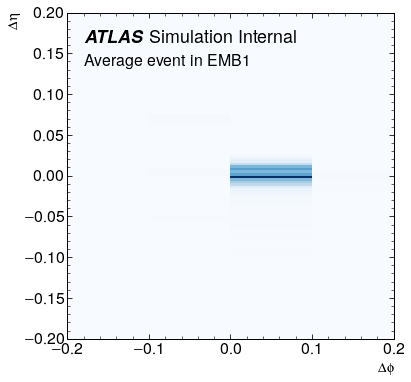

(16, 16)


<Figure size 576x432 with 0 Axes>

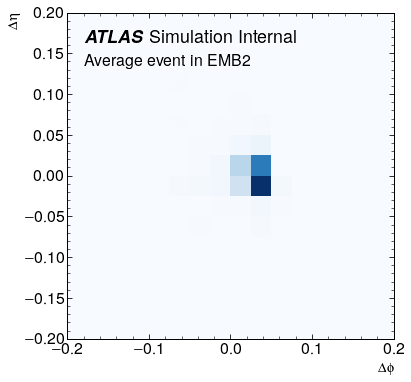

(8, 16)


<Figure size 576x432 with 0 Axes>

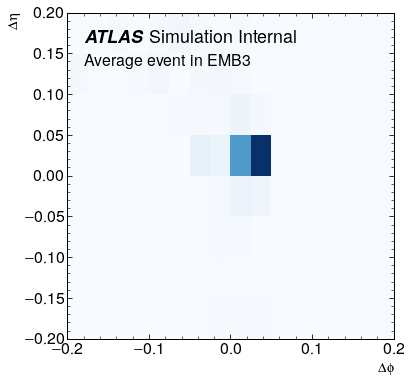

(4, 4)


<Figure size 576x432 with 0 Axes>

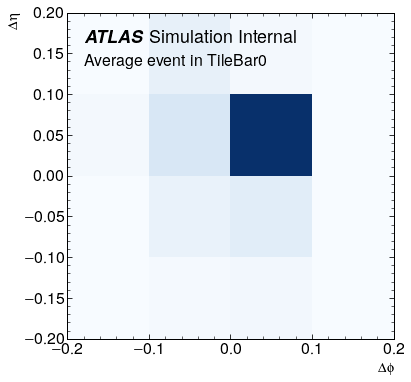

(4, 4)


<Figure size 576x432 with 0 Axes>

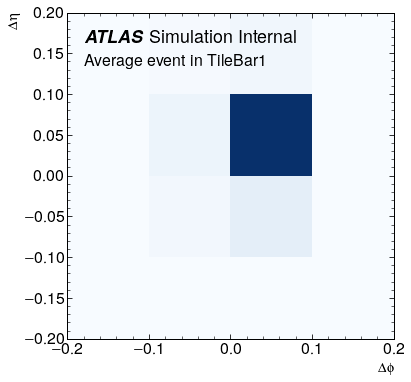

(2, 4)


<Figure size 576x432 with 0 Axes>

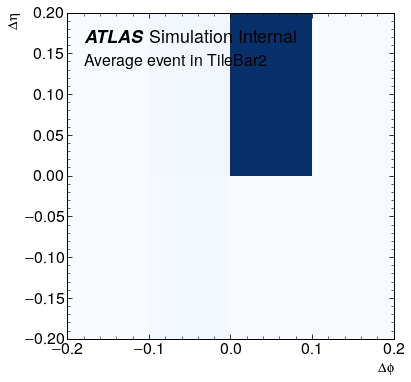

In [13]:
for layer, data in pcells.items():
    print(data.shape)
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.imshow(data, extent=[-0.2, 0.2, -0.2, 0.2],
        cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    ampl.set_xlabel("$\Delta\phi$")
    ampl.set_ylabel("$\Delta\eta$")
    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
    fig.axes[0].text(-0.18, 0.135, 'Average event in '+layer)

#     plt.savefig(plotpath+'average_'+layer+'.pdf')
    plt.show()

In [13]:
eta_bins = {
    layer: np.linspace(-0.2,0.2,meta['len_eta'])
    for layer,meta in mu.cell_meta.items()
}
print(eta_bins)
for k,v in eta_bins.items():
    print(len(v))
print

{'EMB1': array([-0.2       , -0.19685039, -0.19370079, -0.19055118, -0.18740157,
       -0.18425197, -0.18110236, -0.17795276, -0.17480315, -0.17165354,
       -0.16850394, -0.16535433, -0.16220472, -0.15905512, -0.15590551,
       -0.15275591, -0.1496063 , -0.14645669, -0.14330709, -0.14015748,
       -0.13700787, -0.13385827, -0.13070866, -0.12755906, -0.12440945,
       -0.12125984, -0.11811024, -0.11496063, -0.11181102, -0.10866142,
       -0.10551181, -0.1023622 , -0.0992126 , -0.09606299, -0.09291339,
       -0.08976378, -0.08661417, -0.08346457, -0.08031496, -0.07716535,
       -0.07401575, -0.07086614, -0.06771654, -0.06456693, -0.06141732,
       -0.05826772, -0.05511811, -0.0519685 , -0.0488189 , -0.04566929,
       -0.04251969, -0.03937008, -0.03622047, -0.03307087, -0.02992126,
       -0.02677165, -0.02362205, -0.02047244, -0.01732283, -0.01417323,
       -0.01102362, -0.00787402, -0.00472441, -0.0015748 ,  0.0015748 ,
        0.00472441,  0.00787402,  0.01102362,  0.014173

In [12]:
deta = {
    'min':-0.2,'max':0.2,'range':0.4
}
eta_bins = {
    layer: np.zeros(meta['len_eta'])
    for layer,meta in mu.cell_meta.items()
}
# bin = (x-min)*nbins/width
# x = bin*width/nbins+min
for layer,arr in eta_bins.items():
    for i in range(len(arr)):
        arr[i] = i*deta['range']/mu.cell_meta[layer]['len_eta']+deta['min']
print(eta_bins)
for k,v in eta_bins.items():
    print(len(v))

{'EMB1': array([-0.2     , -0.196875, -0.19375 , -0.190625, -0.1875  , -0.184375,
       -0.18125 , -0.178125, -0.175   , -0.171875, -0.16875 , -0.165625,
       -0.1625  , -0.159375, -0.15625 , -0.153125, -0.15    , -0.146875,
       -0.14375 , -0.140625, -0.1375  , -0.134375, -0.13125 , -0.128125,
       -0.125   , -0.121875, -0.11875 , -0.115625, -0.1125  , -0.109375,
       -0.10625 , -0.103125, -0.1     , -0.096875, -0.09375 , -0.090625,
       -0.0875  , -0.084375, -0.08125 , -0.078125, -0.075   , -0.071875,
       -0.06875 , -0.065625, -0.0625  , -0.059375, -0.05625 , -0.053125,
       -0.05    , -0.046875, -0.04375 , -0.040625, -0.0375  , -0.034375,
       -0.03125 , -0.028125, -0.025   , -0.021875, -0.01875 , -0.015625,
       -0.0125  , -0.009375, -0.00625 , -0.003125,  0.      ,  0.003125,
        0.00625 ,  0.009375,  0.0125  ,  0.015625,  0.01875 ,  0.021875,
        0.025   ,  0.028125,  0.03125 ,  0.034375,  0.0375  ,  0.040625,
        0.04375 ,  0.046875,  0.05    ,  0

In [29]:
int((0.197-deta['min'])*128/deta['range'])

127

## Final Code
<div style="text-align: right"> <a href="#Experimentation-with-'graph'-style-inputs">Top</a> </div>

In [34]:
class cell_info:
    meta_tree = 'CellGeo'
    id_branch = 'cell_geo_ID'
    
    def __init__(self, metafile):
        with ur.open(metafile) as ifile:
            self.meta_keys = ifile[self.meta_tree].keys()
            self.celldata = ifile[self.meta_tree].arrays(
                self.meta_keys)
            
        self.id_map = {}
        for i, cell_id in enumerate(self.celldata[self.id_branch][0]):
            self.id_map[cell_id] = i

    def get_cell_info(self, cell_id):
        return {
            k : self.celldata[k][0][self.id_map[cell_id]]
            for k in self.meta_keys
        }
    
    def get_cell_info_vector(self, cell_id):
        res = []
        for k in self.meta_keys:
            if(k == self.id_branch):
                continue
            res.append(self.celldata[k][0][self.id_map[cell_id]])
        return res
    
    def __getitem__(self, key):
        return self.get_cell_info(key)

In [36]:
def create_cell_images(input_file, sampling_layers, c_info=None,
                       eta_range=0.4, phi_range=0.4, print_frequency=100):
    '''Generates images from a 'graph' format input file.
    The output is a dictionary with the following structure:
      images[layer][event_index][eta_index][phi_index]
    The arguments are as follows:
      input_file: path to the desired input file
      sampling_layers: a dict which specifies which layers should
                       have images generated for them; this dict
                       should have entries of the form
                         (int)cell_geo_sampling : 'LayerName'
      c_info: either a path to a root file which contains the
              'CellGeo' tree, or a cell_info object; defaults
              to using input_file to create a cell_info object
              if not provided
      eta/phi_range: full width of the 'window' around cluster
                     centres to render images in; cells outside
                     this window will be ignored
      print_frequency: progress printout will be displayed every
                       integer multiple of this parameter
    '''
    
    if(c_info==None):
        ci = cell_info(input_file)
    elif(isinstance(c_info,str)):
        ci = cell_info(c_info)
    elif(isinstance(c_info,cell_info)):
        ci = c_info
    else:
        raise ValueError('Invalid argument for c_info: must be cell_info object or path to a root file with the CellGeo tree.')
    
    with ur.open(input_file) as ifile:
        entries = ifile['EventTree'].num_entries
        pdata = ifile['EventTree'].arrays(
            ['cluster_cell_ID', 'cluster_cell_E', 'cluster_E', 'cluster_Eta', 'cluster_Phi'])
    
    eta_min = -1*eta_range/2.0
    phi_min = -1*phi_range/2.0
    
    pcells = {
        layer : np.zeros((entries,meta['len_eta'],meta['len_phi']))
        for layer,meta in mu.cell_meta.items()
    }
    
    for evt in range(entries):
        if((evt+1)%print_frequency==0):
            print('Event {}/{}'.format(evt+1,entries))
            
        for clus in range(len(pdata['cluster_cell_ID'][evt])):
            for cell in range(len(pdata['cluster_cell_ID'][evt][clus])):
                c_info = ci[pdata['cluster_cell_ID'][evt][clus][cell]]
                if c_info['cell_geo_sampling'] in sampling_layers:
                    layer = sampling_layers[c_info['cell_geo_sampling']]
                    c_eta = pdata['cluster_Eta'][evt][clus]
                    c_phi = pdata['cluster_Phi'][evt][clus]

                    # calculate eta/phi bins using the formula
                    #   bin = floor( (x-x_min) * nbins / x_range )
                    eta_bin = int(
                        (c_info['cell_geo_eta']-c_eta-eta_min) *
                        mu.cell_meta[layer]['len_eta'] / eta_range
                    )
                    phi_bin = int(
                        (c_info['cell_geo_phi']-c_phi-phi_min) *
                        mu.cell_meta[layer]['len_phi'] / phi_range
                    )

                    # discard cells outside the eta/phi window
                    if(eta_bin<0 or
                       eta_bin>=mu.cell_meta[layer]['len_eta'] or
                       phi_bin<0 or
                       phi_bin>=mu.cell_meta[layer]['len_phi']):
                        continue

                    pcells[layer][evt][eta_bin][phi_bin] += pdata['cluster_cell_E'][evt][clus][cell] / pdata['cluster_E'][evt][clus]
                    # note: 'cluster_E' includes energies from cells with <5 MeV, which are not
                    # included in this dataset, so the energy fraction will be slightly off
        
    return pcells

In [7]:
sampling_layers = {
    1 : 'EMB1', 2 : 'EMB2', 3 : 'EMB3',
    12 : 'TileBar0', 13 : 'TileBar1', 14 : 'TileBar2',
}
ci = cell_info(inputpath+'single_pion.mltree.root')

In [33]:
pcells = create_cell_images(inputpath+'single_pion.mltree.root',sampling_layers)

Event 100/2000
Event 200/2000
Event 300/2000
Event 400/2000
Event 500/2000
Event 600/2000
Event 700/2000
Event 800/2000
Event 900/2000
Event 1000/2000
Event 1100/2000
Event 1200/2000
Event 1300/2000
Event 1400/2000
Event 1500/2000
Event 1600/2000
Event 1700/2000
Event 1800/2000
Event 1900/2000
Event 2000/2000


(2000, 128, 4)


<Figure size 576x432 with 0 Axes>

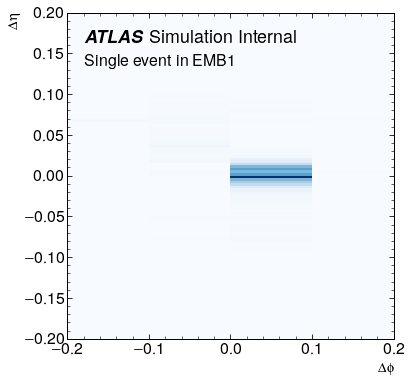

<Figure size 576x432 with 0 Axes>

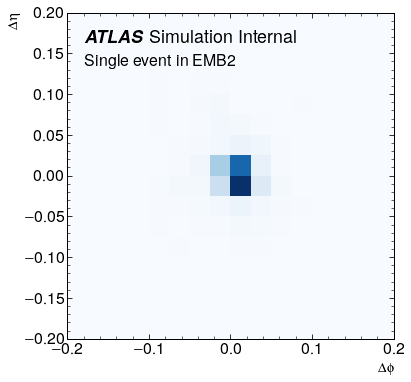

<Figure size 576x432 with 0 Axes>

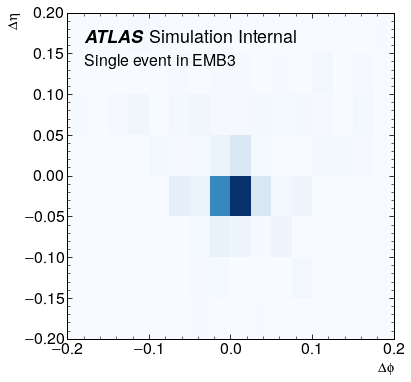

<Figure size 576x432 with 0 Axes>

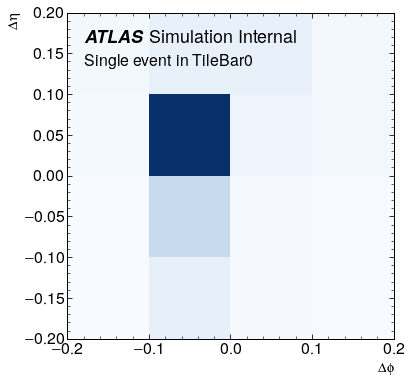

<Figure size 576x432 with 0 Axes>

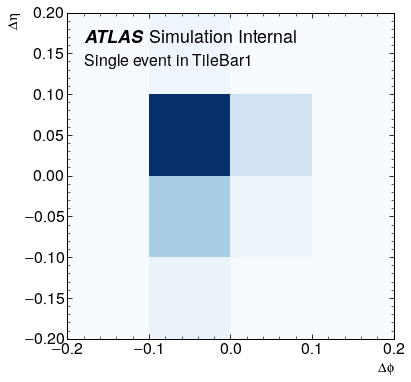

<Figure size 576x432 with 0 Axes>

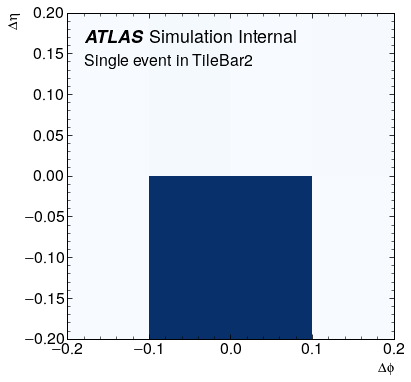

In [25]:
print(pcells['EMB1'].shape)
for layer, data in pcells.items():
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.imshow(data[20], extent=[-0.2, 0.2, -0.2, 0.2],
        cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    ampl.set_xlabel("$\Delta\phi$")
    ampl.set_ylabel("$\Delta\eta$")
    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
    fig.axes[0].text(-0.18, 0.135, 'Single event in '+layer)

#     plt.savefig(plotpath+'average_'+layer+'.pdf')
    plt.show()